### This notebook shows examples of how to manipulate the clinical data and metadata. Three tasks will be accomplished:
#### 1 : Get the path of all BIRADS-1 and BIRADS-2 screening images
#### 2a : Summarize image findings and append to clinical table
#### 2b : Get all BIRADS-0 images, the cancer cases and show their ROIs


In [43]:
import pandas as pd
import numpy as np
import re
import os
import pydicom
import pylibjpeg
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import pyplot as plt
import cv2
import ast
from PIL import Image

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)


Preparing the datasets, and show datasets size:

In [2]:
def stats(df): #the function displays dataframe size, countings of unique patients and unique exams
    print('Dataframe size: ' + str(df.shape))
    try:
        print('# patients: ' + str(df.empi_anon.nunique()))
    except:
        print('# patients: ' + str(df.empi_anon_x.nunique()))
    print('# exams: ' + str(df.acc_anon.nunique()))

In [3]:
#load in clinical and metadata dataframes
# basepath = "./" #define the file directory
basepath = "EMBED_Open_Data-main" #define the file directory
#Load clinical and filter for fields needed for the tasks we are showcasing in this notebook
df_clinical = pd.read_csv("EMBED_OpenData_clinical.csv")

df_clinical = df_clinical[['empi_anon','acc_anon','study_date_anon','asses', 'tissueden',
                          'desc','side','path_severity','numfind','total_L_find','total_R_find',
                          'massshape','massmargin','massdens','calcfind','calcdistri','calcnumber',
                          'ETHNICITY_DESC','ETHNIC_GROUP_DESC','age_at_study','ETHNIC_GROUP_DESC']]
stats(df_clinical)

#Load metadata and filter for fields needed for the tasks we are showcasing in this notebook
df_metadata = pd.read_csv("EMBED_OpenData_metadata.csv")
df_metadata = df_metadata[['anon_dicom_path','empi_anon','acc_anon','study_date_anon',
                            'StudyDescription','SeriesDescription','FinalImageType',
                            'ImageLateralityFinal','ViewPosition','spot_mag','ROI_coords','num_roi']]

stats(df_metadata)

/tmp/ipykernel_138/3082948257.py:5: DtypeWarning: Columns (28,31,33,48,49,53,54,55,56,57,59,81,84,85,93,111) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clinical = pd.read_csv("EMBED_OpenData_clinical.csv")


Dataframe size: (81776, 21)
# patients: 23253
# exams: 72770


/tmp/ipykernel_138/3082948257.py:14: DtypeWarning: Columns (115,116,117,118,119,120,130,132,133,134,135,136,138,143,147,148,149) have mixed types. Specify dtype option on import or set low_memory=False.
  df_metadata = pd.read_csv("EMBED_OpenData_metadata.csv")


Dataframe size: (480323, 12)
# patients: 23256
# exams: 72770


In [4]:
df_clinical.head()

,empi_anon,acc_anon,study_date_anon,asses,tissueden,desc,side,path_severity,numfind,total_L_find,total_R_find,massshape,massmargin,massdens,calcfind,calcdistri,calcnumber,ETHNICITY_DESC,ETHNIC_GROUP_DESC,age_at_study,ETHNIC_GROUP_DESC
0,60696029,8099128854014801,2013-12-30,A,3.0,MG Diagnostic Right,R,NaN,1,0.0,1.0,S,D,NaN,NaN,NaN,0,African American or Black,"Unreported, Unknown, Unavailable",69.652354,"Unreported, Unknown, Unavailable"
1,90986305,5156106114290009,2013-08-26,P,3.0,MG Diagnostic Left,L,NaN,1,1.0,0.0,F,NaN,NaN,NaN,NaN,0,African American or Black,"Unreported, Unknown, Unavailable",42.741466,"Unreported, Unknown, Unavailable"
2,78097721,3065491565033830,2013-02-19,N,3.0,MG Screening Bilateral w/CAD,NaN,NaN,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,Caucasian or White,Non-Hispanic or Latino,60.967713,Non-Hispanic or Latino
3,43734324,1878527667143380,2013-02-08,A,3.0,MG Screening Bilateral w/CAD,R,2.0,1,0.0,1.0,NaN,NaN,NaN,G,NaN,0,African American or Black,Non-Hispanic or Latino,56.329699,Non-Hispanic or Latino
4,28410573,8493926076199113,2013-02-18,B,3.0,MG Screening Bilateral w/CAD,B,NaN,1,1.0,1.0,O,U,NaN,NaN,NaN,0,Asian,Non-Hispanic or Latino,50.544501,Non-Hispanic or Latino


In [5]:
df_metadata.head()

,anon_dicom_path,empi_anon,acc_anon,study_date_anon,StudyDescription,SeriesDescription,FinalImageType,ImageLateralityFinal,ViewPosition,spot_mag,ROI_coords,num_roi
0,/mnt/NAS2/mammo/anon_dicom/cohort_1/66685715/1...,66685715,7208547536889815,2017-05-15 00:00:00,MG Screening Bilateral,L MLO,2D,L,MLO,NaN,(),0
1,/mnt/NAS2/mammo/anon_dicom/cohort_1/30864920/1...,30864920,7774461277054123,2019-08-05 00:00:00,MG Screen Bilat w/Tomo/CAD Stnd Protocol,R MLO,2D,R,MLO,NaN,(),0
2,/mnt/NAS2/mammo/anon_dicom/cohort_1/30864920/1...,30864920,7774461277054123,2019-08-05 00:00:00,MG Screen Bilat w/Tomo/CAD Stnd Protocol,R MLO C-View,cview,R,MLO,NaN,(),0
3,/mnt/NAS2/mammo/anon_dicom/cohort_1/30864920/1...,30864920,7774461277054123,2019-08-05 00:00:00,MG Screen Bilat w/Tomo/CAD Stnd Protocol,R CC,2D,R,CC,NaN,(),0
4,/mnt/NAS2/mammo/anon_dicom/cohort_1/30864920/1...,30864920,7774461277054123,2019-08-05 00:00:00,MG Screen Bilat w/Tomo/CAD Stnd Protocol,R CC C-View,cview,R,CC,NaN,(),0


In [6]:
data = pd.merge(df_metadata, df_clinical, on=['acc_anon','empi_anon'], how='left')
data.head()

,anon_dicom_path,empi_anon,acc_anon,study_date_anon_x,StudyDescription,SeriesDescription,FinalImageType,ImageLateralityFinal,ViewPosition,spot_mag,ROI_coords,num_roi,study_date_anon_y,asses,tissueden,desc,side,path_severity,numfind,total_L_find,total_R_find,massshape,massmargin,massdens,calcfind,calcdistri,calcnumber,ETHNICITY_DESC,ETHNIC_GROUP_DESC,age_at_study,ETHNIC_GROUP_DESC
0,/mnt/NAS2/mammo/anon_dicom/cohort_1/66685715/1...,66685715,7208547536889815,2017-05-15 00:00:00,MG Screening Bilateral,L MLO,2D,L,MLO,NaN,(),0,2017-05-15,N,2.0,MG Screening Bilateral,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,Caucasian or White,"Unreported, Unknown, Unavailable",43.428681,"Unreported, Unknown, Unavailable"
1,/mnt/NAS2/mammo/anon_dicom/cohort_1/30864920/1...,30864920,7774461277054123,2019-08-05 00:00:00,MG Screen Bilat w/Tomo/CAD Stnd Protocol,R MLO,2D,R,MLO,NaN,(),0,2019-08-05,N,2.0,MG Screen Bilat w/Tomo/CAD Stnd Protocol,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,African American or Black,"Unreported, Unknown, Unavailable",65.227897,"Unreported, Unknown, Unavailable"
2,/mnt/NAS2/mammo/anon_dicom/cohort_1/30864920/1...,30864920,7774461277054123,2019-08-05 00:00:00,MG Screen Bilat w/Tomo/CAD Stnd Protocol,R MLO C-View,cview,R,MLO,NaN,(),0,2019-08-05,N,2.0,MG Screen Bilat w/Tomo/CAD Stnd Protocol,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,African American or Black,"Unreported, Unknown, Unavailable",65.227897,"Unreported, Unknown, Unavailable"
3,/mnt/NAS2/mammo/anon_dicom/cohort_1/30864920/1...,30864920,7774461277054123,2019-08-05 00:00:00,MG Screen Bilat w/Tomo/CAD Stnd Protocol,R CC,2D,R,CC,NaN,(),0,2019-08-05,N,2.0,MG Screen Bilat w/Tomo/CAD Stnd Protocol,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,African American or Black,"Unreported, Unknown, Unavailable",65.227897,"Unreported, Unknown, Unavailable"
4,/mnt/NAS2/mammo/anon_dicom/cohort_1/30864920/1...,30864920,7774461277054123,2019-08-05 00:00:00,MG Screen Bilat w/Tomo/CAD Stnd Protocol,R CC C-View,cview,R,CC,NaN,(),0,2019-08-05,N,2.0,MG Screen Bilat w/Tomo/CAD Stnd Protocol,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,African American or Black,"Unreported, Unknown, Unavailable",65.227897,"Unreported, Unknown, Unavailable"


In [7]:
cols = [
    "anon_dicom_path","empi_anon","acc_anon","desc","tissueden","asses","massshape",
    "massmargin","massdens","calcfind","calcdistri","ImageLateralityFinal","ViewPosition",
    "num_roi","ROI_coords"
]

subs_data = data[cols]

In [8]:
subs_data.head()

,anon_dicom_path,empi_anon,acc_anon,desc,tissueden,asses,massshape,massmargin,massdens,calcfind,calcdistri,ImageLateralityFinal,ViewPosition,num_roi,ROI_coords
0,/mnt/NAS2/mammo/anon_dicom/cohort_1/66685715/1...,66685715,7208547536889815,MG Screening Bilateral,2.0,N,NaN,NaN,NaN,NaN,NaN,L,MLO,0,()
1,/mnt/NAS2/mammo/anon_dicom/cohort_1/30864920/1...,30864920,7774461277054123,MG Screen Bilat w/Tomo/CAD Stnd Protocol,2.0,N,NaN,NaN,NaN,NaN,NaN,R,MLO,0,()
2,/mnt/NAS2/mammo/anon_dicom/cohort_1/30864920/1...,30864920,7774461277054123,MG Screen Bilat w/Tomo/CAD Stnd Protocol,2.0,N,NaN,NaN,NaN,NaN,NaN,R,MLO,0,()
3,/mnt/NAS2/mammo/anon_dicom/cohort_1/30864920/1...,30864920,7774461277054123,MG Screen Bilat w/Tomo/CAD Stnd Protocol,2.0,N,NaN,NaN,NaN,NaN,NaN,R,CC,0,()
4,/mnt/NAS2/mammo/anon_dicom/cohort_1/30864920/1...,30864920,7774461277054123,MG Screen Bilat w/Tomo/CAD Stnd Protocol,2.0,N,NaN,NaN,NaN,NaN,NaN,R,CC,0,()


In [9]:
from pathlib import Path
image_path = Path("../emory/images_png")
image_paths = list(image_path.rglob("*.png"))

len(image_paths)

15558

In [10]:
def extract_identifier(path):
    try:
        patient_id = path.parent.parts[3]
        fn = path.name.split(".")[-2]
    except Exception as e:
        patient_id = path.split('/')[6]
        fn = path.split('/')[-1].split('.')[-2]
    return patient_id, fn
    
anon_d = {extract_identifier(path) for path in subs_data['anon_dicom_path'].values}
image_d = {extract_identifier(path) for path in image_paths}

image_identifiers = anon_d.intersection(image_d)

In [11]:
# Assuming `subs_data` is a DataFrame and `anon_dicom_path` is a column containing paths
subs_data_filtered = subs_data[subs_data['anon_dicom_path'].apply(lambda x: extract_identifier(x) in image_identifiers)].reset_index(drop=True)
subs_data_filtered.head()

,anon_dicom_path,empi_anon,acc_anon,desc,tissueden,asses,massshape,massmargin,massdens,calcfind,calcdistri,ImageLateralityFinal,ViewPosition,num_roi,ROI_coords
0,/mnt/NAS2/mammo/anon_dicom/cohort_1/17059932/1...,17059932,2526193688405600,MG Screening Bilateral,2.0,N,NaN,NaN,NaN,NaN,NaN,R,NaN,0,()
1,/mnt/NAS2/mammo/anon_dicom/cohort_1/17059932/1...,17059932,2526193688405600,MG Screening Bilateral,2.0,N,NaN,NaN,NaN,NaN,NaN,L,NaN,0,()
2,/mnt/NAS2/mammo/anon_dicom/cohort_1/14521844/1...,14521844,8215874515695783,MG Diagnostic Mammo Bilateral,3.0,P,T,NaN,NaN,NaN,NaN,L,MLO,0,()
3,/mnt/NAS2/mammo/anon_dicom/cohort_1/14521844/1...,14521844,8215874515695783,MG Diagnostic Mammo Bilateral,3.0,P,T,NaN,NaN,NaN,NaN,R,MLO,0,()
4,/mnt/NAS2/mammo/anon_dicom/cohort_1/14521844/1...,14521844,8215874515695783,MG Diagnostic Mammo Bilateral,3.0,P,T,NaN,NaN,NaN,NaN,R,CC,0,()


In [12]:
images_data = subs_data_filtered.copy()

In [13]:
# Step 1: Create a dictionary mapping (patient_id, fn) to image_path
image_path_dict = {extract_identifier(path): path for path in image_paths}

# Step 2: Add the 'Image_Paths' column to subs_data_filtered by looking up each identifier in the dictionary
images_data['Image_Paths'] = images_data['anon_dicom_path'].apply(
    lambda x: image_path_dict.get(extract_identifier(x), None)  # If not found, default to None
)

# Display the resulting DataFrame
images_data.reset_index(drop=True, inplace=True)
images_data.head()

,anon_dicom_path,empi_anon,acc_anon,desc,tissueden,asses,massshape,massmargin,massdens,calcfind,calcdistri,ImageLateralityFinal,ViewPosition,num_roi,ROI_coords,Image_Paths
0,/mnt/NAS2/mammo/anon_dicom/cohort_1/17059932/1...,17059932,2526193688405600,MG Screening Bilateral,2.0,N,NaN,NaN,NaN,NaN,NaN,R,NaN,0,(),../emory/images_png/17059932/1.2.397.200037.91...
1,/mnt/NAS2/mammo/anon_dicom/cohort_1/17059932/1...,17059932,2526193688405600,MG Screening Bilateral,2.0,N,NaN,NaN,NaN,NaN,NaN,L,NaN,0,(),../emory/images_png/17059932/1.2.398.200037.91...
2,/mnt/NAS2/mammo/anon_dicom/cohort_1/14521844/1...,14521844,8215874515695783,MG Diagnostic Mammo Bilateral,3.0,P,T,NaN,NaN,NaN,NaN,L,MLO,0,(),../emory/images_png/14521844/1.2.841.113622.2....
3,/mnt/NAS2/mammo/anon_dicom/cohort_1/14521844/1...,14521844,8215874515695783,MG Diagnostic Mammo Bilateral,3.0,P,T,NaN,NaN,NaN,NaN,R,MLO,0,(),../emory/images_png/14521844/1.2.841.113622.2....
4,/mnt/NAS2/mammo/anon_dicom/cohort_1/14521844/1...,14521844,8215874515695783,MG Diagnostic Mammo Bilateral,3.0,P,T,NaN,NaN,NaN,NaN,R,CC,0,(),../emory/images_png/14521844/1.2.841.113622.2....


In [14]:
# az = images_data[images_data['massshape'].isnull()]
# az[~az['calcfind'].isnull()]

In [15]:
def findings(row):
    fng = []
    if row['massshape'] in ['T', 'B', 'S', 'F', 'V']:
        fng.append("Asymmetry")
    elif row['massshape']in ['Q', 'A']:
        fng.append("Architectural distortion")
    elif (row['massshape'] in ['G', 'R', 'O', 'X', 'N', 'Y', 'D', 'L']) or (row['massmargin'] in ['D', 'U', 'M', 'I', 'S']) or (row['massdens'] in ['+', '-', '=']):
        fng.append("Mass")
    
    if (row['calcdistri'] is not np.nan) or (row['calcfind'] is not np.nan):
        fng.append("Suspicious Calcification")
        
    return fng if fng else None
  
images_data['findings'] = images_data.apply(lambda row:findings(row),axis=1)

In [16]:
tissue_map = {1.0:"DENSITY A", 2.0:"DENSITY B", 3.0:"DENSITY C", 4.0:"DENSITY D", 5.0:"MALE"}
ass_map = {"A":"BIRADS 0", "N":"BIRADS 1", "B":"BIRADS 2", "P":"BIRADS 3", "S":"BIRADS 4",
          "M":"BIRADS 5", "K":"BIRADS 6"}
mshape_map = {"S":"Asymmetry","F":"Focal asymetry","O":"Oval","X":"Irregular","G":"Generic",
                 "Q":"Questioned architectural distortion","A":"Architectural distortion",
                 "R":"Round","Y":"Lumph Node","N":"Intramammary lymph node","B":"Global asymetry",
                 "T":"Asymmectric tubular structure/solitary dilated duct"}
mmargin_map = {"D":"Circumscribed","U":"Obscured","M":"Microlobulated","I":"Indistinct","S":"Spiculated"}
mdens_map = {"=":"Isodense","+":"High density","-":"Low density",0:"Fat containing"}
calcfind_map = {"A": "Amorphous","9": "Benign","H": "Coarse heterogeneous","C": "Course Popcorn-like",
                 "D": "Dystrophic","E": "Rim","F": "Fine-linear (casting)","B": "Fine linear-branching (casting)",
                 "G": "Generic","I": "Fine pleomorphic","L": "Large Rodlike","M": "Milk of calcium",
                 "J": "Oil Cyst","K": "Pleomorphic","P": "Punctate","R": "Round","S": "Skin",
                 "O": "Lucent-centered","U": "Suture","V": "Vascular","Q": "Coarse"}
calcdistri_map = {"G": "Grouped","S": "Segmental","R": "Regional","D": "Diffuse/scattered",
                  "L": "Linear","C": "Clustered"}



images_data["tissueden"] = images_data["tissueden"].map(tissue_map)
images_data["asses"] = images_data["asses"].map(ass_map)
images_data["massshape"] = images_data["massshape"].map(mshape_map)
images_data["massmargin"] = images_data["massmargin"].map(mmargin_map)
images_data["massdens"] = images_data["massdens"].map(mdens_map)
images_data["calcdistri"] = images_data["calcdistri"].map(calcdistri_map)
images_data["calcfind"] = images_data["calcfind"].map(calcfind_map)

In [17]:
images_roi = images_data[images_data['num_roi']>=1].copy().reset_index(drop=True)

In [18]:
def display_images(data, idx):
    # Find the unique patient ID
    unique_patient_id = data['empi_anon'].iloc[idx]
    
    # Filter data for this patient ID
    patient_data = data[data['empi_anon'] == unique_patient_id]
    
    # Set the plot size
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
    axes = axes.ravel()

    for i, row in enumerate(patient_data.itertuples()):
        # Build image path
        img_file_path = row.Image_Paths

        # Open and show image
        if os.path.exists(img_file_path):
            img = Image.open(img_file_path)
            for roi in ast.literal_eval(row.ROI_coords):
                y1, x1, y2, x2 = roi
                try:
                    axes[i].imshow(img, cmap='gray')

                    # Draw bounding box
                    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
                    axes[i].add_patch(rect)
                except Exception as e:
                    print(f"Cannot Display {img_file_path}, because of error:{e}")
                    break
        else:
            axes[i].text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
        
        # Set title with image attributes
        title_text = f"{i} Desc: {row.desc}   Findings {row.findings}"
        axes[i].set_title(title_text, fontsize=8)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


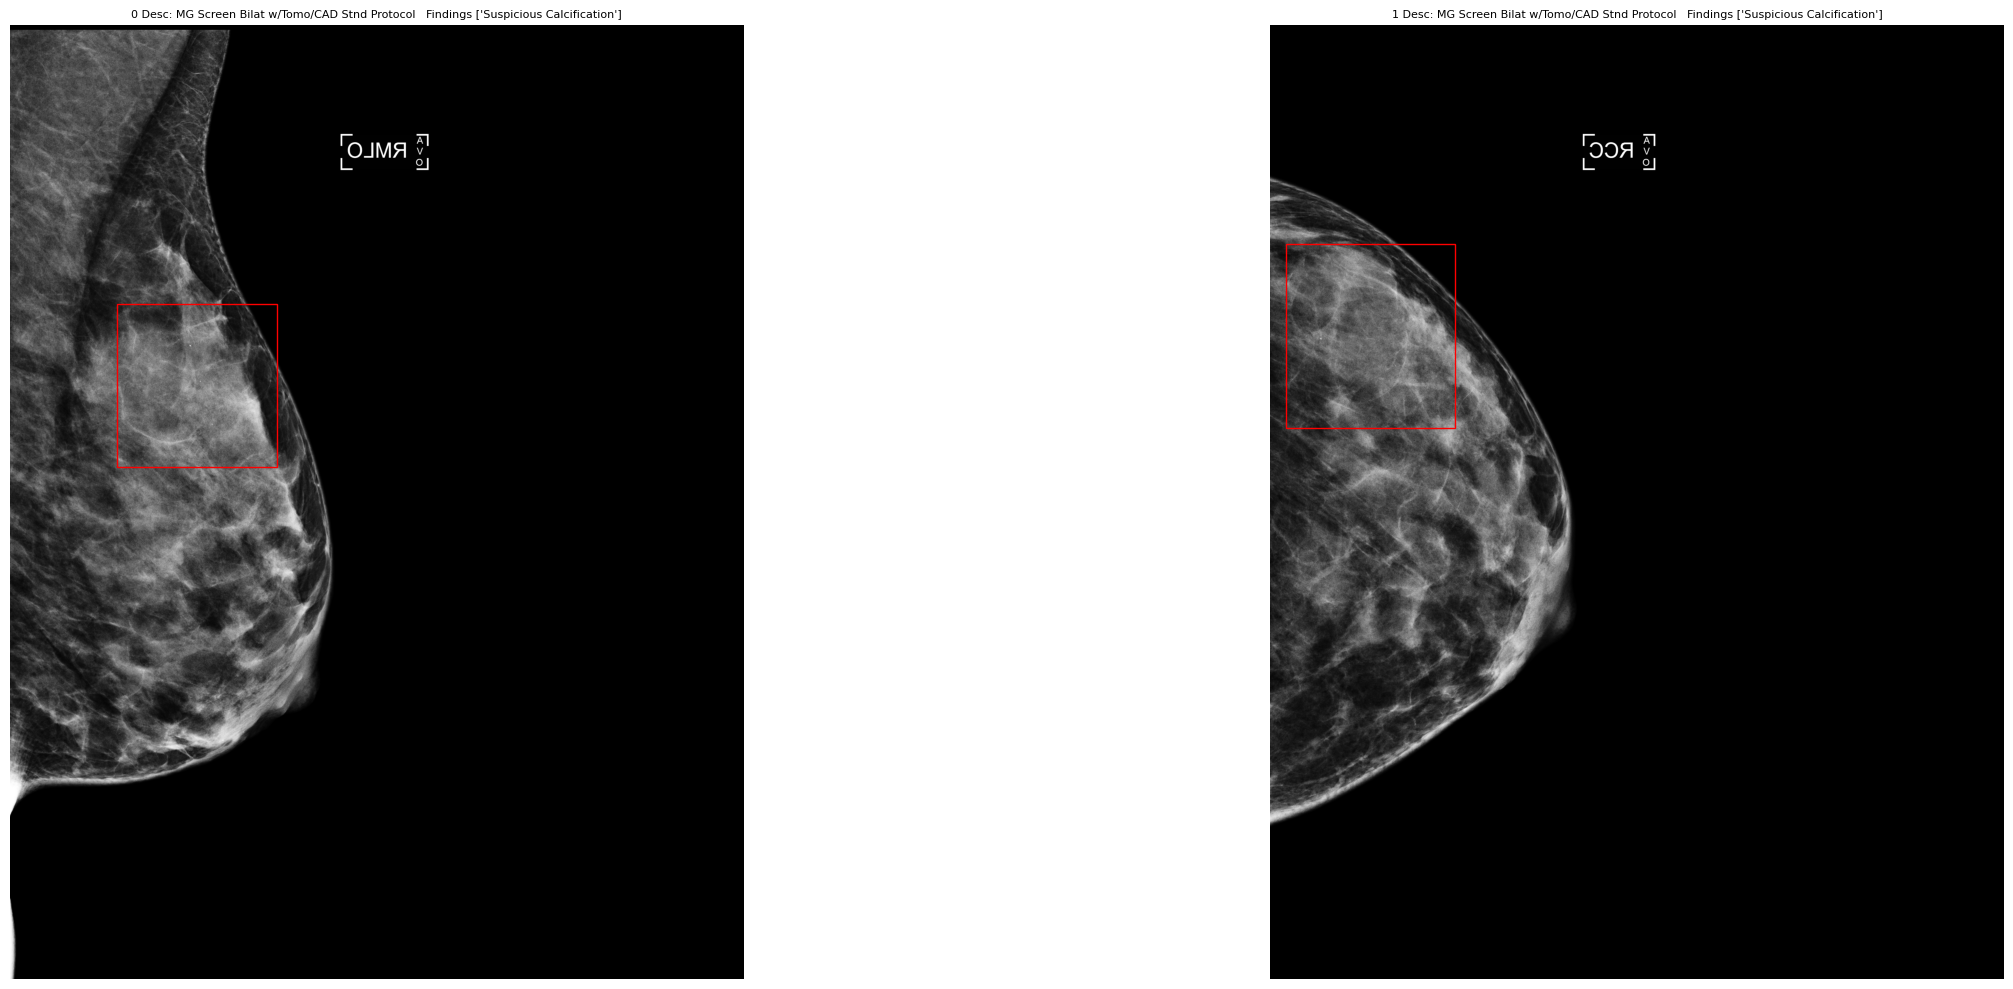

In [19]:
import random
idx = random.randint(0, images_roi.shape[0])
display_images(images_roi, idx)

Cannot Display ../emory/images_png/11051076/1.2.846.113685.2750825172.1578031730.4988.45627/84402274634272899997006853960846585695.png, because of error:index 2 is out of bounds for axis 0 with size 2


IndexError: index 2 is out of bounds for axis 0 with size 2

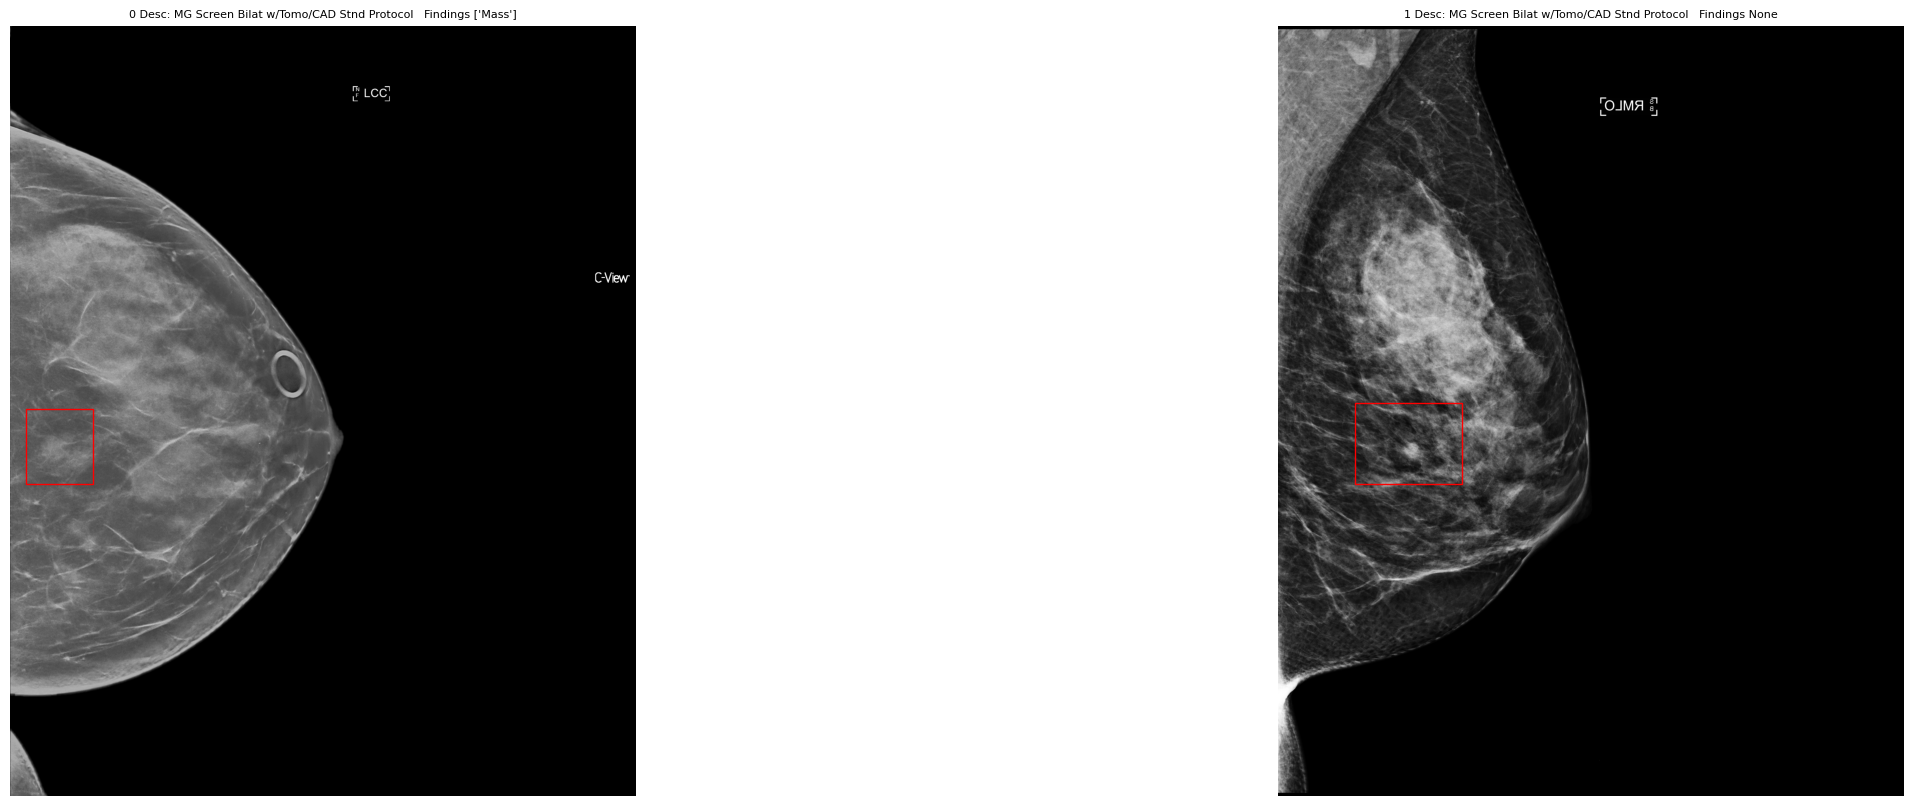

In [22]:
idx = random.randint(0, images_roi.shape[0])
display_images(images_roi, idx)

Cannot Display ../emory/images_png/13291529/1.2.845.113688.2750828164.1543654383.3830.888/10541464622501114095794244464806927068.png, because of error:index 2 is out of bounds for axis 0 with size 2


IndexError: index 2 is out of bounds for axis 0 with size 2

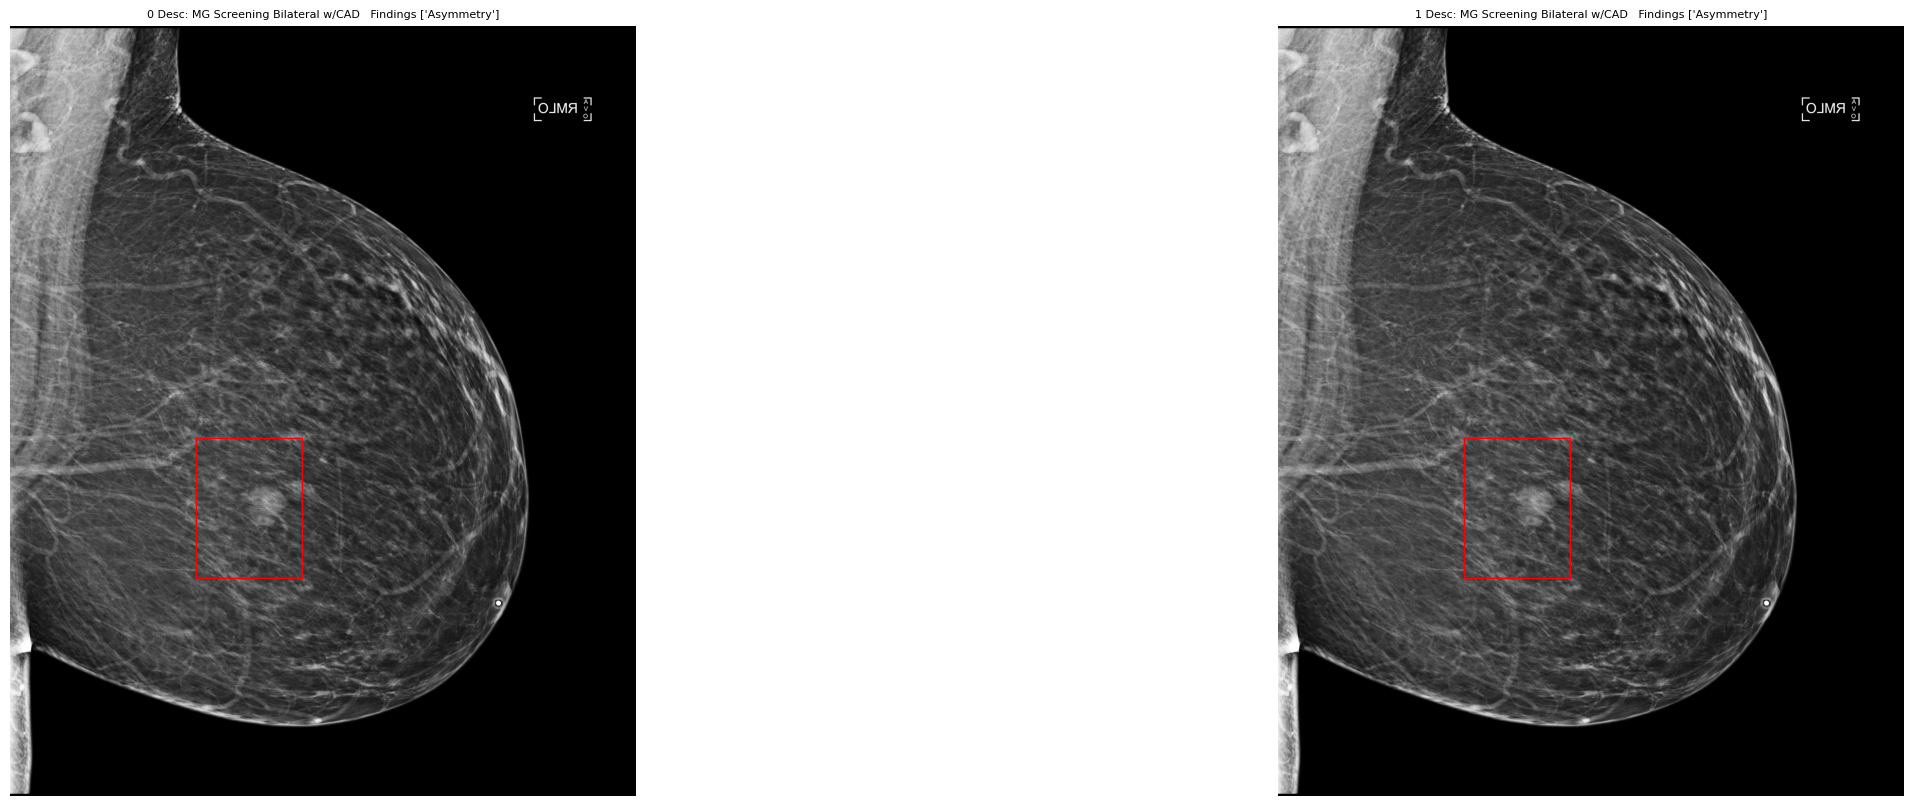

In [23]:
idx = random.randint(0, images_roi.shape[0])
display_images(images_roi, idx)

In [31]:
from collections import defaultdict

category = defaultdict(int)

for i, row in images_data.iterrows():
    cats = row['findings']
    if cats:
        for cat in cats:
            category[cat] += 1

category

defaultdict(int,
            {'Asymmetry': 2213,
             'Architectural distortion': 193,
             'Suspicious Calcification': 1660,
             'Mass': 1454})

In [35]:
def chosen_category(cats) -> str:
    weights = []
    if cats:
        for cat in cats:
            weights.append(category[cat])

        idx = np.argmax(weights)
        return cats[idx]


images_data['category'] = images_data['findings'].apply(chosen_category)

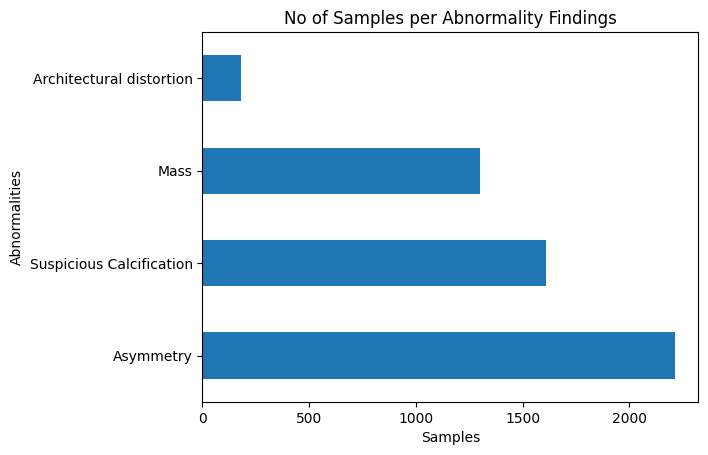

In [37]:
images_data['category'].value_counts().plot(kind='barh', title="No of Samples per Abnormality Findings", ylabel="Abnormalities", xlabel="Samples");

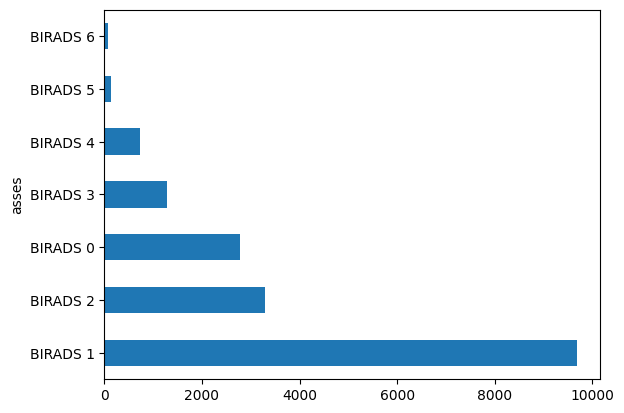

In [38]:
images_data['asses'].value_counts().plot(kind='barh');

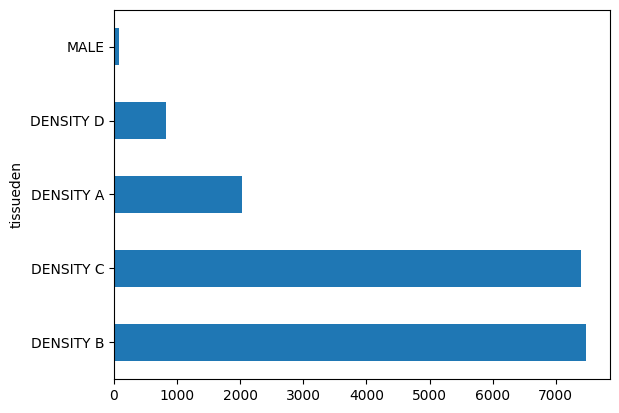

In [39]:
images_data['tissueden'].value_counts().plot(kind='barh');

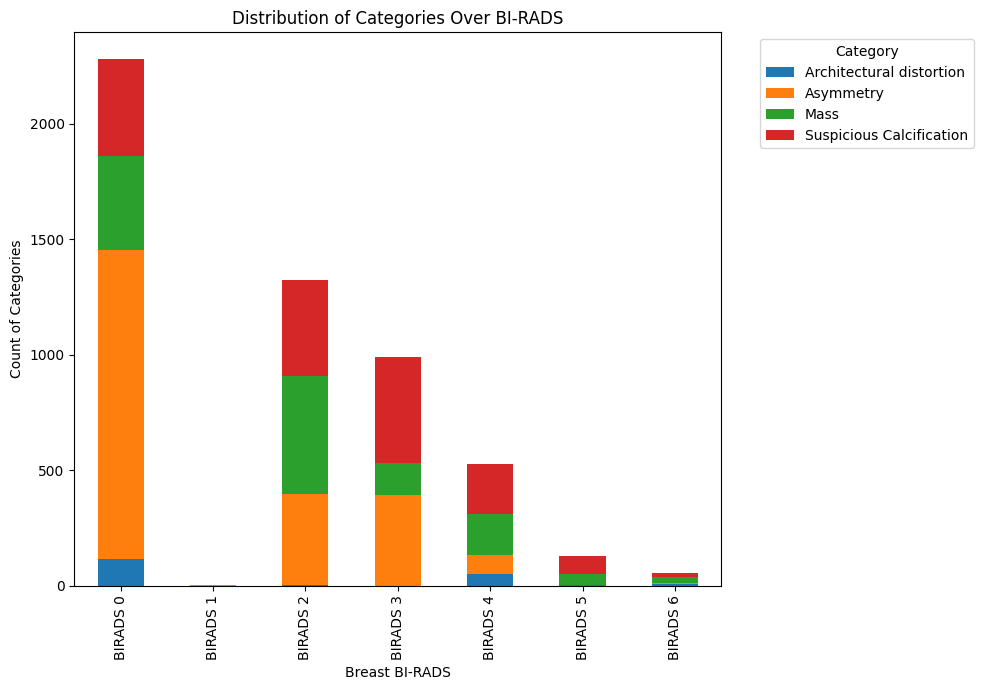

In [40]:
# Group data by 'breast_birads' and 'category', and count occurrences of 'category'
grouped_data = images_data.groupby(['asses', 'category']).size().unstack(fill_value=0)

# Plotting the data
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Distribution of Categories Over BI-RADS')
plt.xlabel('Breast BI-RADS')
plt.ylabel('Count of Categories')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

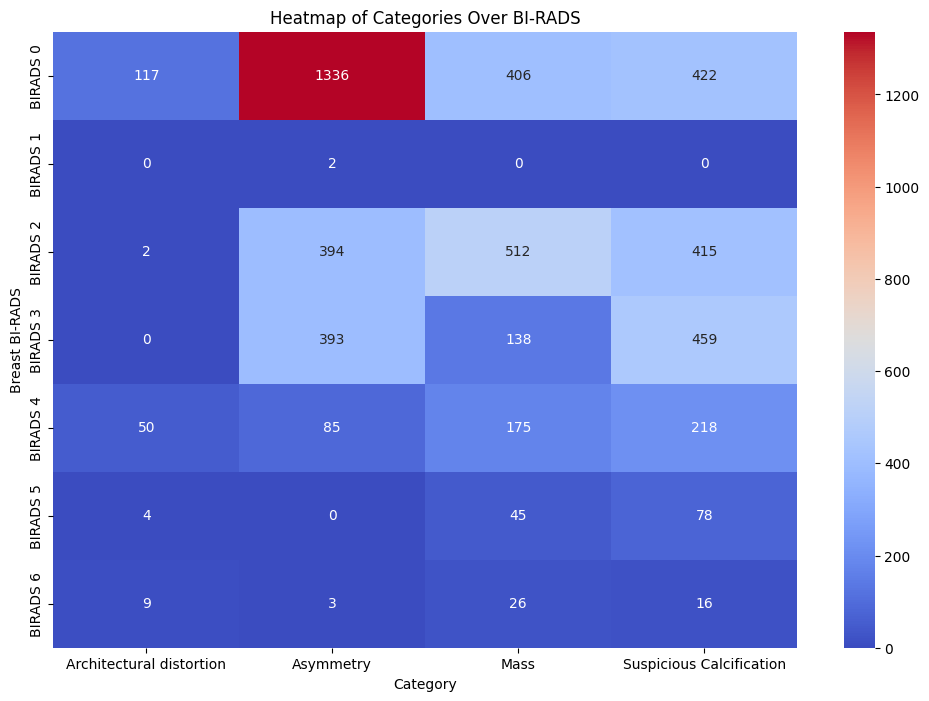

In [44]:
grouped_data = images_data.groupby(['asses', 'category']).size().unstack(fill_value=0)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, cmap='coolwarm', fmt="d")
plt.title('Heatmap of Categories Over BI-RADS')
plt.xlabel('Category')
plt.ylabel('Breast BI-RADS')
plt.show()


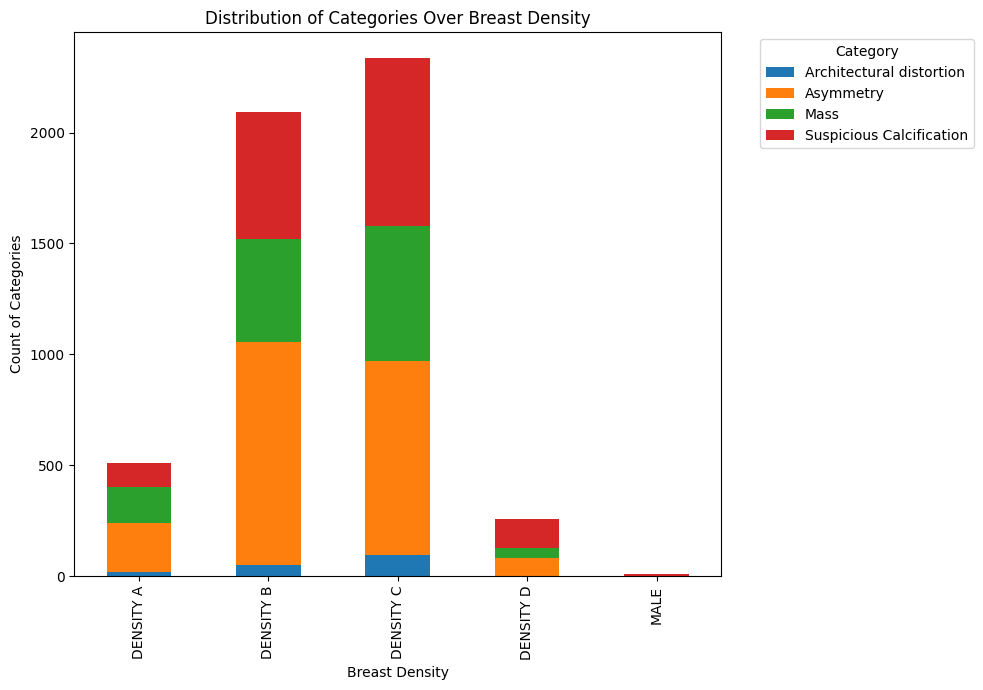

In [45]:
# Group data by 'breast_birads' and 'category', and count occurrences of 'category'
grouped_data = images_data.groupby(['tissueden', 'category']).size().unstack(fill_value=0)

# Plotting the data
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Distribution of Categories Over Breast Density')
plt.xlabel('Breast Density')
plt.ylabel('Count of Categories')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

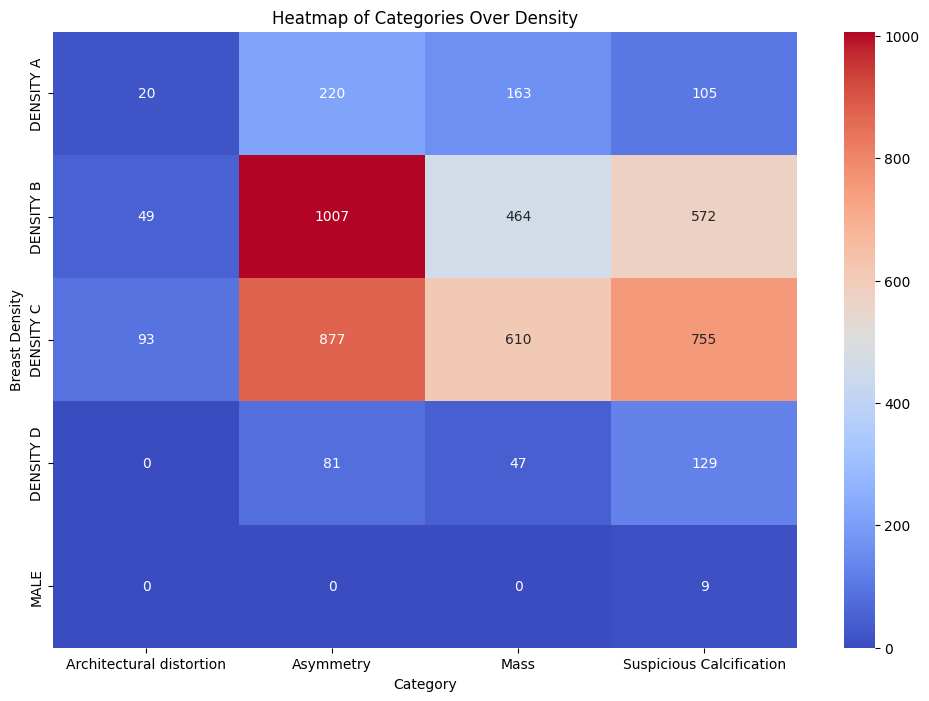

In [46]:
grouped_data = images_data.groupby(['tissueden', 'category']).size().unstack(fill_value=0)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, cmap='coolwarm', fmt="d")
plt.title('Heatmap of Categories Over Density')
plt.xlabel('Category')
plt.ylabel('Breast Density')
plt.show()


In [50]:
final_data = images_data.drop(['anon_dicom_path','empi_anon','acc_anon','massshape',
                               'massmargin','massdens','calcfind','calcdistri'],axis=1)

In [51]:
final_data.to_csv("../emory_final.csv", index=False)